TODO：

- [Done] 问题分析、数据处理、编码，2017301
- [Done] GradientBoostingRegressor算法参数优化， 20170302
- [Done] 加入weekday和weekend字段做feature， 20170303
- [Done] extra_user_view.txt字段的使用，20170304
- [Done] 数据清洗，20170305
- [Done] 其他算法的尝试和优化, 20170305
- 三方数据如天气、空气指数的引入

In [1]:
import xgboost as xgb

# 导入user_pay数据

In [2]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from time import time
from sklearn.metrics import mean_squared_error
import datetime as dt
import matplotlib.pyplot as plt

def encode_onehot(df, cols):
    vec = DictVectorizer()
    vec_data = pd.DataFrame(vec.fit_transform(df[cols].to_dict(orient='records')).toarray())
    vec_data.columns = vec.get_feature_names()
    vec_data.index = df.index
    df = df.drop(cols, axis=1)
    df = df.join(vec_data)
    return df

### Preprocess user_pay data                                                                                                                                                                                
t0 = time()
user_pay_names=['user_id', 'shop_id', 'time']
df = pd.read_csv('user_pay.txt', names=user_pay_names)
df['day'] = pd.Series(pd.to_datetime(df['time'])).dt.date
print 'Load data finished.'

# df contains 'user_id, shop_id, day'                                                                                                                                                                       
del df['time']
df = df.groupby(['shop_id','day'],as_index=False).count()
df['pay_count'] = df['user_id']
del df['user_id']
df['pay_count'] = pd.to_numeric(df['pay_count'], errors='coerce').fillna(0)
print 'Group data user_pay info finished.'

Load data finished.
Group data user_pay info finished.


- 将shop_id对应的所有pay_count信息sum求和之后，使用matplotlib的柱状图展示，以发现其中的outliers

   shop_id  pay_count
0        1      92689
1        2      39110
2        3      10469
3        4      13606
4        5      31455

Shop pay_count data shape:  2000


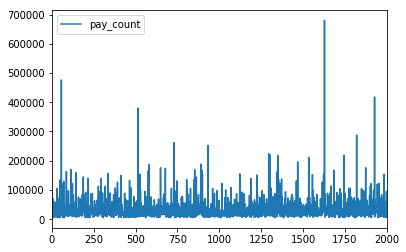

In [3]:
shop_total_pay_df = df.groupby(['shop_id'],as_index=False).sum()
print shop_total_pay_df.head()
print
print 'Shop pay_count data shape: ', shop_total_pay_df.shape[0]

shop_total_pay_df['pay_count'].plot()
plt.legend(loc='best')
plt.show()

* 异常点

In [4]:
print shop_total_pay_df[shop_total_pay_df['pay_count'] > 350000]

      shop_id  pay_count
57         58     476209
516       517     380184
1628     1629     680464
1927     1928     418208


In [5]:
pay_mean = shop_total_pay_df['pay_count'].mean()
pay_max = shop_total_pay_df['pay_count'].max()
pay_min = shop_total_pay_df['pay_count'].min()
#(x - np.mean(x)) / (np.max(x) - np.min(x))
print 'Pay count mean: ', pay_mean
print 'Pay count Max:  ', pay_max
print 'Pay count Min:  ', pay_min

Pay count mean:  34837.055
Pay count Max:   680464
Pay count Min:   4321


In [6]:
tmp_df = shop_total_pay_df['pay_count'].apply(lambda x: (x - pay_mean) * 1.0 /(pay_max - pay_min))
print tmp_df.head()

0    0.085562
1    0.006320
2   -0.036040
3   -0.031400
4   -0.005002
Name: pay_count, dtype: float64


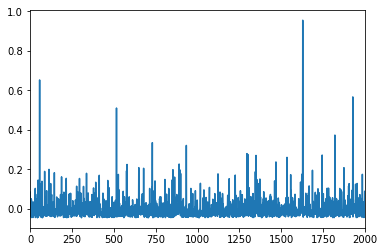

In [7]:
tmp_df.plot()
plt.show()

* 经过Normalization的处理发现各点之间的差值虽然变小，但是outlier还是存在较大区间的差异，因而后续处理fit的时候考虑将outlier移除以使模型能更好的吻合，在最终结果中再将对应的outlier做还原处理

In [8]:
# 移除异常数据
df = df[df['pay_count'] < 350000]

# 导入shop_info数据

In [9]:
print df.head()

   shop_id         day  pay_count
0        1  2015-10-10        188
1        1  2015-10-11        272
2        1  2015-10-12        257
3        1  2015-10-13        239
4        1  2015-10-14        277


In [10]:
shop_info_names=['shop_id','city_name','location_id','per_pay','score','comment_cnt','shop_level','cate_1_name','cate_2_name','cate_3_name']
shop_df = pd.read_csv('shop_info.txt', names=shop_info_names)
del shop_df['cate_3_name']

merge_names=['city_name','location_id','per_pay','score','comment_cnt','shop_level','cate_1_name','cate_2_name']
df = df.merge(shop_df, left_on='shop_id', right_on='shop_id', how='left')
print 'Data after merged(shop_info, user_pay pay count in shop per/day): '
print df.head()
# df contains "'pay_count','shop_id','day', 'city_name','location_id','per_pay','score','comment_cnt','shop_level','cate_1_name','cate_2_name'"

Data after merged(shop_info, user_pay pay count in shop per/day): 
   shop_id         day  pay_count city_name  location_id  per_pay  score  \
0        1  2015-10-10        188        湖州          885        8    4.0   
1        1  2015-10-11        272        湖州          885        8    4.0   
2        1  2015-10-12        257        湖州          885        8    4.0   
3        1  2015-10-13        239        湖州          885        8    4.0   
4        1  2015-10-14        277        湖州          885        8    4.0   

   comment_cnt  shop_level cate_1_name cate_2_name  
0         12.0           2          美食        休闲茶饮  
1         12.0           2          美食        休闲茶饮  
2         12.0           2          美食        休闲茶饮  
3         12.0           2          美食        休闲茶饮  
4         12.0           2          美食        休闲茶饮  


# 导入user_view数据

In [11]:
user_view_names=['user_id', 'shop_id', 'view_time']
view_df = pd.read_csv('user_view.txt', names=user_view_names)
view_df['day'] = pd.Series(pd.to_datetime(view_df['view_time'])).dt.date
print view_df.head()

    user_id  shop_id            view_time         day
0  13201967     1197  2016-10-21 18:00:00  2016-10-21
1  19461365     1197  2016-06-28 23:00:00  2016-06-28
2  15022321     1197  2016-07-16 19:00:00  2016-07-16
3   5440872     1197  2016-07-15 07:00:00  2016-07-15
4  12594529     1197  2016-08-07 16:00:00  2016-08-07


In [12]:
del view_df['view_time']
view_df = view_df.groupby(['shop_id','day'],as_index=False).count()
view_df['view_count'] = view_df['user_id']
del view_df['user_id']

# 移除异常数据
view_df = view_df[view_df['view_count'] < 5000]

# Merge user_view with user_pay and shop_info data                                                                                                                                                          
df = df.merge(view_df, left_on=['shop_id','day'], right_on=['shop_id','day'], how='left')

### Clean data fill 0 for NaN value in column                                                                                                                                                               
df = df.fillna(0)

print 'Data after merged(user_view, user_pay, view per/day on shop): '
print df.head()

Data after merged(user_view, user_pay, view per/day on shop): 
   shop_id         day  pay_count city_name  location_id  per_pay  score  \
0        1  2015-10-10        188        湖州          885        8    4.0   
1        1  2015-10-11        272        湖州          885        8    4.0   
2        1  2015-10-12        257        湖州          885        8    4.0   
3        1  2015-10-13        239        湖州          885        8    4.0   
4        1  2015-10-14        277        湖州          885        8    4.0   

   comment_cnt  shop_level cate_1_name cate_2_name  view_count  
0         12.0           2          美食        休闲茶饮         0.0  
1         12.0           2          美食        休闲茶饮         0.0  
2         12.0           2          美食        休闲茶饮         0.0  
3         12.0           2          美食        休闲茶饮         0.0  
4         12.0           2          美食        休闲茶饮         0.0  


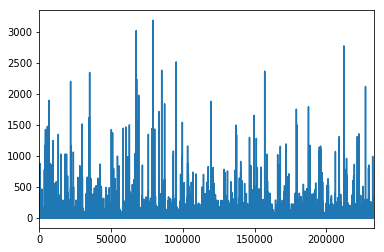

In [13]:
view_sum_df = view_df.groupby(['shop_id','day'],as_index=False).sum()
view_sum_df['view_count'].plot()
plt.show()

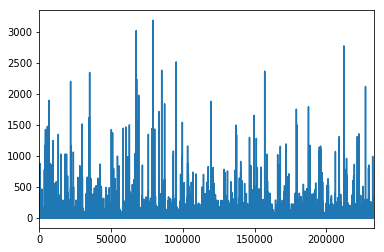

In [14]:
view_sum_df = view_df.groupby(['shop_id','day'],as_index=False).sum()
view_sum_df = view_sum_df[view_sum_df['view_count'] < 5000]
view_sum_df['view_count'].plot()
plt.show()

In [10]:
print view_sum_df.head()

   shop_id         day  view_count
0        1  2016-06-22          10
1        1  2016-06-23          18
2        1  2016-06-24           5
3        1  2016-06-25          22
4        1  2016-06-26          15


In [11]:
print view_sum_df[view_sum_df['view_count'] > 5000]
print df.head()

Empty DataFrame
Columns: [shop_id, day, view_count]
Index: []
   shop_id         day  pay_count city_name  location_id  per_pay  score  \
0        1  2015-10-10        188        湖州          885        8    4.0   
1        1  2015-10-11        272        湖州          885        8    4.0   
2        1  2015-10-12        257        湖州          885        8    4.0   
3        1  2015-10-13        239        湖州          885        8    4.0   
4        1  2015-10-14        277        湖州          885        8    4.0   

   comment_cnt  shop_level cate_1_name cate_2_name  view_count  
0         12.0           2          美食        休闲茶饮         0.0  
1         12.0           2          美食        休闲茶饮         0.0  
2         12.0           2          美食        休闲茶饮         0.0  
3         12.0           2          美食        休闲茶饮         0.0  
4         12.0           2          美食        休闲茶饮         0.0  


* 根据上图可以发现shop_id:1629在其中也是outlier，其view访问数量也在很大程度上远远超过其他商家，推测可能该商家在那天前后做了大规模推广或者特定平台的活动，导致当天展示、浏览及支付量暴增。

### Data process for one hot encoding and datetime to ordinal

In [15]:
# Data process
df['weekday'] = df['day'].apply(lambda x: dt.datetime.weekday(x))
df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)
df['day'] = df['day'].apply(lambda x: x.toordinal())

labels = df['pay_count']
del df['pay_count']

### One Hot encoding for column: cate_1_name, cate_2_name, city_name                                                                                                                                        
# Vectorize the categorical columns: e & f                                                                                                                                                                  
df = encode_onehot(df, cols=['city_name','cate_1_name','cate_2_name'])

# print 'train features: ' + str(df.columns.values)                                                                                                                                                         
train_features,test_features,train_labels,test_labels=train_test_split(df,labels,test_size=0.2,random_state=0)

print 'train_features header:'
print train_features.head()

train_features header:
        shop_id     day  location_id  per_pay  score  comment_cnt  shop_level  \
527745     1763  736171          160       12    3.0         10.0           2   
98053       330  736155          680       18    3.0          1.0           0   
522442     1745  735997          287       13    3.0         20.0           2   
595020     1986  736106           60       13    2.0          8.0           2   
188466      636  736158           31        1    4.0          2.0           0   

        view_count  weekday  is_weekend      ...       city_name=镇江  \
527745        19.0        1           0      ...                0.0   
98053         36.0        6           1      ...                0.0   
522442         0.0        2           0      ...                0.0   
595020         0.0        6           1      ...                0.0   
188466         3.0        2           0      ...                0.0   

        city_name=长沙  city_name=长治  city_name=阜阳  city_name=阳江 

In [12]:
print train_labels.head()

527745    205
98053      51
522442    486
595020     95
188466      7
Name: pay_count, dtype: int64


### 移除异常点数据或先对数据做临时规则处理

In [13]:
print train_labels.shape[0]

479420


## XGBoost算法训练

#### Step 1: Fix learning rate and number of estimators for tuning tree-based parameters

/Users/michaelfeng/code/tf/venv/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/michaelfeng/code/tf/venv/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/michaelfeng/code/tf/venv/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either u


Model Report
Score :  0.825051928067
Mean Square Error :  3143.49179567


/Users/michaelfeng/code/tf/venv/lib/python2.7/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


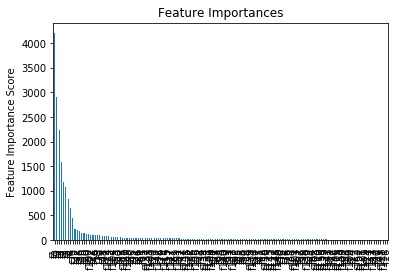

Predict time:  7310.544 s


In [55]:
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st
import pandas as pd
import numpy as np
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search


start = time()
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
train_features_scale = scaler1.fit_transform(train_features)
train_labels_scale = scaler2.fit_transform(train_labels)

test_features_scale = scaler1.fit_transform(test_features)
test_labels_scale = scaler2.fit_transform(test_labels)

start = time()
# clf = xgb.XGBRegressor(n_estimators=200, max_depth=12)
clf = xgb.XGBRegressor(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight = 1,
    objective='count:poisson',
    nthread=8,
    seed=27)

useTrainCV=True
# cv_folds=2
# early_stopping_rounds=1

cv_folds=5
early_stopping_rounds=50
xgb_param = clf.get_xgb_params()
xgtrain = xgb.DMatrix(train_features_scale, label=train_labels_scale)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=clf.get_params()['n_estimators'], nfold=cv_folds, metrics='mae', early_stopping_rounds=early_stopping_rounds)
clf.set_params(n_estimators=cvresult.shape[0])
clf.fit(train_features_scale, train_labels_scale, eval_metric='mae', verbose=True)

test_predictions = clf.predict(test_features_scale)

#Print model report:
print "\nModel Report"
print "Score : ", clf.score(test_features_scale, test_labels_scale)
print "Mean Square Error : ",mean_squared_error(test_labels, scaler2.inverse_transform(test_predictions))

feat_imp = pd.Series(clf.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()
print "Predict time: ", round(time() - start, 3), "s"


In [56]:
print clf.get_params()['n_estimators']

print cvresult.min()

cvresult

1000
test-mae-mean     0.006356
test-mae-std      0.000015
train-mae-mean    0.006255
train-mae-std     0.000005
dtype: float64


,test-mae-mean,test-mae-std,train-mae-mean,train-mae-std
0,0.430228,0.000056,0.430228,0.000014
1,0.389201,0.000052,0.389202,0.000012
2,0.352077,0.000048,0.352078,0.000010
3,0.318494,0.000046,0.318494,0.000010
4,0.288104,0.000041,0.288106,0.000009
5,0.260616,0.000040,0.260618,0.000010
6,0.235746,0.000039,0.235748,0.000009
7,0.213254,0.000036,0.213256,0.000008
8,0.192909,0.000031,0.192909,0.000011
9,0.174513,0.000031,0.174513,0.000011


In [105]:
clf.get_params()

{'base_score': 0.5,
 'colsample_bylevel': 1,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 1000,
 'nthread': 8,
 'objective': 'count:poisson',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 27,
 'silent': True,
 'subsample': 0.8}

#### Step 2: Tune max_depth and min_child_weight

In [106]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

# Use the estimator and learning_rate above to for grid search
clf = xgb.XGBRegressor(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight = 1,
    objective='count:poisson',
    nthread=8,
    seed=27)

gsearch1 = GridSearchCV(estimator = clf, param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=5)
gsearch1.fit(train_features_scale, train_labels_scale)
print gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

[mean: -0.00019, std: 0.00001, params: {'max_depth': 3, 'min_child_weight': 1}, mean: -0.00019, std: 0.00001, params: {'max_depth': 3, 'min_child_weight': 3}, mean: -0.00018, std: 0.00001, params: {'max_depth': 3, 'min_child_weight': 5}, mean: -0.00011, std: 0.00001, params: {'max_depth': 5, 'min_child_weight': 1}, mean: -0.00011, std: 0.00001, params: {'max_depth': 5, 'min_child_weight': 3}, mean: -0.00011, std: 0.00000, params: {'max_depth': 5, 'min_child_weight': 5}, mean: -0.00008, std: 0.00000, params: {'max_depth': 7, 'min_child_weight': 1}, mean: -0.00008, std: 0.00000, params: {'max_depth': 7, 'min_child_weight': 3}, mean: -0.00008, std: 0.00000, params: {'max_depth': 7, 'min_child_weight': 5}, mean: -0.00006, std: 0.00000, params: {'max_depth': 9, 'min_child_weight': 1}, mean: -0.00007, std: 0.00000, params: {'max_depth': 9, 'min_child_weight': 3}, mean: -0.00007, std: 0.00000, params: {'max_depth': 9, 'min_child_weight': 5}] {'max_depth': 9, 'min_child_weight': 1} -6.39671278

In [112]:
print gsearch1.best_params_
print gsearch1.best_score_
print gsearch1.best_estimator_

{'max_depth': 9, 'min_child_weight': 1}
-6.39671278857e-05
XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=8,
       objective='count:poisson', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8)


In [ ]:
param_test2b = {
 'min_child_weight':[6,8,10,12]
}
gsearch2b = GridSearchCV(estimator = xgb.XGBRegressor(learning_rate=0.1, n_estimators=1000, max_depth=9,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'count:poisson', nthread=8, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=5)
gsearch2b.fit(train_features_scale, train_labels_scale)
modelfit(gsearch3.best_estimator_, train, predictors)
gsearch2b.grid_scores_, gsearch2b.best_params_, gsearch2b.best_score_

#### Step 3: Tune gamma

In [ ]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = xgb.XGBRegressor(learning_rate =0.1, n_estimators=1000, max_depth=9,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'count:poisson', nthread=8, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=5)
gsearch3.fit(train_features_scale, train_labels_scale)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

Output --->>>

[mean: -0.00007, std: 0.00000, params: {'gamma': 0.0}, mean: -0.00008, std: 0.00000, params: {'gamma': 0.1}, mean: -0.00010, std: 0.00000, params: {'gamma': 0.2}, mean: -0.00011, std: 0.00000, params: {'gamma': 0.3}, mean: -0.00011, std: 0.00000, params: {'gamma': 0.4}]

{'gamma': 0.0}

-6.5072929476e-05

Score :  0.888063331

#### Step 4: Tune subsample and colsample_bytree

In [ ]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=1000, max_depth=9,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.9,
 objective= 'count:poisson', nthread=8, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=5)
gsearch4.fit(train_features_scale, train_labels_scale)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

{'subsample': 0.8, 'colsample_bytree': 0.9}

-6.43601744369e-05

Train time:  28280.336 s

#### Step 5: Tuning Regularization Parameters

In [ ]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=1000, max_depth=9,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.9,
 objective= 'count:poisson', nthread=8, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=5)
gsearch6.fit(train_features_scale, train_labels_scale)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

[mean: -0.00006, std: 0.00000, params: {'reg_alpha': 1e-05}, mean: -0.00006, std: 0.00000, params:\
 {'reg_alpha': 0.01}, mean: -0.00006, std: 0.00000, params: {'reg_alpha': 0.1}, mean: -0.00007, st\
d: 0.00000, params: {'reg_alpha': 1}, mean: -0.00042, std: 0.00002, params: {'reg_alpha': 100}]

{'reg_alpha': 0.1}

-5.98067147561e-05

In [ ]:
param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate=0.1, n_estimators=1000, max_depth=9,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.9,reg_alpha=0.1
 objective= 'count:poisson', nthread=8, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=5)
gsearch7.fit(train_features_scale, train_labels_scale)
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

#### See final result

In [123]:
xgb3 = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=9,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.9,
 reg_alpha=0.1,
 objective= 'reg:linear',
 nthread=8,
 scale_pos_weight=1,
 eval_metric = "rmse",
 seed=27)

start = time()
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
train_features_scale = scaler1.fit_transform(train_features)
train_labels_scale = scaler2.fit_transform(train_labels)

test_features_scale = scaler1.fit_transform(test_features)
test_labels_scale = scaler2.fit_transform(test_labels)
xgb3.fit(train_features_scale, train_labels_scale)
pred = xgb3.predict(train_labels_scale)

#Print model report:
print "Model Report \n"
print "Score : ", xgb3.score(test_features_scale, test_labels_scale)
print "Mean Square Error : ", mean_squared_error(test_labels, scaler2.inverse_transform(pred))

Model Report 

Score : 

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

#### Step 6: Reducing Learning Rate

In [ ]:
xgb4 = xgb.XGBRegressor(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=9,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.9,
 reg_alpha=0.1,
 objective= 'reg:linear',
 nthread=8,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, train, predictors)

## SGDRegressor算法训练

In [38]:
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler

scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
train_features_scale = scaler1.fit_transform(train_features)
train_labels_scale = scaler2.fit_transform(train_labels)

test_features_scale = scaler1.fit_transform(test_features)
test_labels_scale = scaler2.fit_transform(test_labels)

start = time()
clf = linear_model.SGDRegressor(loss='squared_loss',penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, n_iter=5, shuffle=True, verbose=0, epsilon=0.1, random_state=None, learning_rate='constant', eta0=0.01, power_t=0.25, warm_start=False, average=False)
clf.fit(train_features_scale, train_labels_scale)
print "Train time: ", round(time() - start, 3), "s"

start = time()
pred = clf.predict(test_features_scale)

print 'Score:', clf.score(test_features_scale, test_labels_scale)
print "Predict time: ", round(time() - start, 3), "s"
print 'Mean squared error: ', mean_squared_error(test_labels, scaler2.inverse_transform(pred))

/Users/michaelfeng/code/tf/venv/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/michaelfeng/code/tf/venv/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/michaelfeng/code/tf/venv/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either u

Train time:  1.967 s
Score: 0.240954743112
Predict time:  0.032 s
Mean squared error:  13638.6329365


/Users/michaelfeng/code/tf/venv/lib/python2.7/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [33]:
pred = scaler2.inverse_transform(pred)
print pred

[ 158.8066615    83.3005532    51.81166508 ...,  208.88902085   23.63206743
   83.25334537]


/Users/michaelfeng/code/tf/venv/lib/python2.7/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


## Neutral Network训练

In [47]:
from sklearn.neural_network import MLPRegressor

start = time()
clf =  MLPRegressor(random_state=42, activation='logistic')
clf.fit(train_features, train_labels)
print "Train time: ", round(time() - start, 3), "s"

start = time()
pred = clf.predict(test_features)
print 'Score:', clf.score(test_features, test_labels)
print "Predict time: ", round(time() - start, 3), "s"
print 'Mean squared error: ', mean_squared_error(test_labels, pred)
print 'Loss', clf.loss_

Train time:  23.514 s
Score: -2.61602127607e-05
Predict time:  0.721 s
Mean squared error:  17968.6120192
Loss 8651.82605989


### TODO

- Add cluster column info in order to improve regression result.
- Add weather data


## GradientBoostingRegressor训练

In [130]:
start = time()
clf =  GradientBoostingRegressor(n_estimators=2000, learning_rate=0.1, max_depth=9, min_samples_split=30, random_state=0, loss='ls')
clf.fit(train_features, train_labels)
print "Train time: ", round(time() - start, 3), "s"

start = time()
pred = clf.predict(test_features)
print 'Score:', clf.score(test_features, test_labels)
print "Predict time: ", round(time() - start, 3), "s"
print 'Mean squared error: ', mean_squared_error(test_labels, pred)

Train time:  16523.448 s
Score: 0.940694463442
Predict time:  18.619 s
Mean squared error:  1065.61030041


In [131]:
### Predict data that 2016-11-1 to 2016-11-14
date_list = ['2016-11-01','2016-11-02','2016-11-03','2016-11-04','2016-11-05','2016-11-06','2016-11-07','2016-11-08','2016-11-09','2016-11-10','2016-11-11','2016-11-12','2016-11-13','2016-11-14']

date_df = pd.DataFrame(data=date_list, columns=['day'])
date_df['day'] = pd.Series(pd.to_datetime(date_df['day'])).dt.date
print date_df.head()

shopid_df = pd.DataFrame(shop_df['shop_id'])
shopid_df['key'] = 0
date_df['key'] = 0
pred_df = pd.merge(shopid_df, date_df, on='key', how='left')
del pred_df['key']
# predict features contains 'shop_id, day, is_weekend, weekday, view_count, shop_info ...'
pred_df = pred_df.merge(shop_df, left_on='shop_id', right_on='shop_id', how='left') 

# Add view_count column in order to keep same number features as train data
pred_df['view_count'] = np.random.choice(range(1, 100), pred_df.shape[0])
pred_df['weekday'] = pred_df['day'].apply(lambda x: dt.datetime.weekday(x))
pred_df['is_weekend'] = pred_df['weekday'].apply(lambda x: 1 if x >= 5 else 0)
pred_df['day'] = pred_df['day'].apply(lambda x: x.toordinal())

## TODO optimize generate average view_count for every shop_id
pred_df = pred_df.fillna(0)
pred_features_df = encode_onehot(pred_df, cols=['city_name','cate_1_name','cate_2_name'])
pred_features_ori_df = pred_df[['shop_id','day']]


print '###########'
print pred_features_ori_df.head()

start = time()
#pred_labels_df = pd.DataFrame(pred_df['shop_id'])

## Start for transform
# pred_features_df = scaler1.fit_transform(pred_features_df)
# End transform

pred_labels = clf.predict(pred_features_df)
print 'Final Predict time: ', round(time() - start,3),'s'
#print 'Final Predict result len: ', pred_labels.shape[0]
print 'Final Predict feature len: ', pred_features_df.shape[0]


## Start for transform
# pred_labels = scaler2.inverse_transform(pred_labels)
# End transform

pred_labels_df = pd.DataFrame(pred_labels)
print 'Final Predict label header: '
print pred_labels_df.head()

# print 'Final Predict features header: '
# print pred_features_df.head()

pred_labels_df['pay_count'] = pd.DataFrame(data=pred_labels_df,columns=['pay_count'])

# pred_features_ori_df contains 'shop_id', 'day numbers'
date_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
date_df['day'] = pd.DataFrame(data=date_list, columns=['day'])
pred_features_ori_df = pd.merge(shopid_df, date_df, on='key', how='left')

print 'pred_features_ori_df header: '
print pred_features_ori_df.head()
print len(pred_features_ori_df)


print 'Begin concating data:'
result = pd.concat([pred_labels_df, pred_features_ori_df], axis=1, join_axes=[pred_labels_df.index])
del result['key']

result.to_csv('result.txt', header=False, index=False)
print result.head()

# result.txt format: pay_count, shop_id, day
print 'Finish predict.'

          day
0  2016-11-01
1  2016-11-02
2  2016-11-03
3  2016-11-04
4  2016-11-05
###########
   shop_id     day
0        1  736269
1        1  736270
2        1  736271
3        1  736272
4        1  736273
Final Predict time:  1.933 s
Final Predict feature len:  28000
Final Predict label header: 
            0
0  177.701795
1  187.306587
2  202.006967
3  227.872601
4  262.869336
pred_features_ori_df header: 
   shop_id  key  day
0        1    0    1
1        1    0    2
2        1    0    3
3        1    0    4
4        1    0    5
28000
Begin concating data:
            0  pay_count  shop_id  day
0  177.701795        NaN        1    1
1  187.306587        NaN        1    2
2  202.006967        NaN        1    3
3  227.872601        NaN        1    4
4  262.869336        NaN        1    5
Finish predict.


#### XGBoosting seems like a good algorithm. But not as much as Gradient Boost Regression in this case.